<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Data-Loading" data-toc-modified-id="Data-Loading-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Data Loading</a></span></li><li><span><a href="#Feature-selection.-XGB" data-toc-modified-id="Feature-selection.-XGB-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Feature selection. XGB</a></span></li><li><span><a href="#Feature-selection.-RANDOM-FOREST-and-Single-Decision-Tree" data-toc-modified-id="Feature-selection.-RANDOM-FOREST-and-Single-Decision-Tree-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Feature selection. RANDOM FOREST and Single Decision Tree</a></span></li><li><span><a href="#Feature-Importance,-как-атрибут-модели" data-toc-modified-id="Feature-Importance,-как-атрибут-модели-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Feature Importance, как атрибут модели</a></span></li><li><span><a href="#RFE-(Recursive-Feature-Elimination)" data-toc-modified-id="RFE-(Recursive-Feature-Elimination)-0.5"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>RFE (Recursive Feature Elimination)</a></span></li><li><span><a href="#Permutation-Importance-(PI)" data-toc-modified-id="Permutation-Importance-(PI)-0.6"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>Permutation Importance (PI)</a></span></li><li><span><a href="#WoE-(Weight-of-Evidence)-and-IV-(Information-Value)" data-toc-modified-id="WoE-(Weight-of-Evidence)-and-IV-(Information-Value)-0.7"><span class="toc-item-num">0.7&nbsp;&nbsp;</span>WoE (Weight of Evidence) and IV (Information Value)</a></span></li></ul></li><li><span><a href="#Оценка-качества-модели" data-toc-modified-id="Оценка-качества-модели-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Оценка качества модели</a></span><ul class="toc-item"><li><span><a href="#Литература" data-toc-modified-id="Литература-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Литература</a></span></li><li><span><a href="#Д/З" data-toc-modified-id="Д/З-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Д/З</a></span></li></ul></li></ul></div>

In [38]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix


# from ELI5 import PermutationImportance
# несмотря на установку - не подключается.



def evaluation(y_true, y_pred, y_prob, verbose=True):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    if verbose:
        print('Precision: {}'.format(precision))
        print('Recall: {}'.format(recall))
        print('F1: {}'.format(f1))
        print('Log Loss: {}'.format(ll)) 
        print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc


def plot_importance(importance, features, name, plot=True):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    if plot:
        plt.figure(figsize=(16,6))
        plt.bar(range(fi.shape[0]), fi[1], align='center')
        plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
        plt.title(name)
        plt.show()
    return fi

def tree_fit_predict(clf, X_train, y_train, X_test, y_test, show_metrics=True):
    
    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1], verbose=show_metrics)
    return clf, f1_test 

def tree_fit_predict_dt(clf, X_train, y_train, X_test, y_test, show_metrics=True):
    
    clf.fit(X_train, y_train)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1], verbose=show_metrics)
    return clf, f1_test 

In [2]:
!ls ../data

dataset_raw_test.csv
dataset_raw_train.csv
dataset_test.csv
dataset_train.csv


### Data Loading

In [3]:
%%time
path_train = "../data/dataset_train.csv" # data placed on folder not in git folder
dataset = pd.read_csv(path_train, sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов

# почему-то в моей версии SMOTE не предусмотрен аргумент ratio, поэтому я посчитал вручную и поставил нужное кол-во 1

X_train_balanced, y_train_balanced = SMOTE(sampling_strategy={1:98590}, 
                                           random_state=42, n_jobs=-1).fit_sample(X_train, y_train)

Wall time: 5.26 s


In [4]:
print(y_train.value_counts(normalize=True))
print(y_train.value_counts().sum())
print(y_train_balanced.value_counts(normalize=True))
print(y_train_balanced.value_counts())

0    0.970554
1    0.029446
Name: is_churned, dtype: float64
328632
0    0.763882
1    0.236118
Name: is_churned, dtype: float64
0    318955
1     98590
Name: is_churned, dtype: int64


### Feature selection. XGB

Precision: 0.29401351786289026
Recall: 0.4404532304725169
F1: 0.3526346265199768
Log Loss: 0.1337393446041017
ROC AUC: 0.8986019729851382


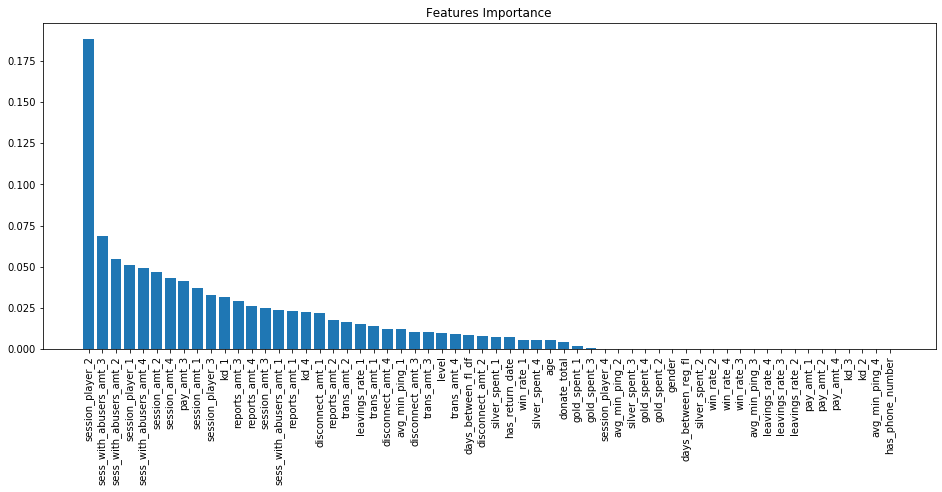

In [14]:
# 2.1. Standart feature selection. XGB Boost
clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10,
                           n_jobs=-1)
# 2.1.1. Base model
fitted_clf, f1_test_base = tree_fit_predict(clf, X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance = plot_importance(fitted_clf.feature_importances_, X.columns, 'Features Importance', plot=True)

In [15]:
# 2.1.2. dependency calculation
# takes a few minutes

zero_feats = feature_importance[1].value_counts().max()
non_zero_feats = len(feature_importance) - zero_feats
feature_range = range(1, non_zero_feats)
f1_list = []

for n in feature_range:
    X_train_cutted = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:n]]
    X_test_cutted = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:n]]
    fitted_clf, f1_test = tree_fit_predict(clf, X_train_cutted, y_train_balanced, X_test_cutted, y_test, 
                                           show_metrics=False)
    #print(f'for best {n} features achieved f1={f1_test:.3f}')
    f1_list.append(f1_test)
    
best_idx = np.array(f1_list).argmax()
best_n = feature_range[best_idx]

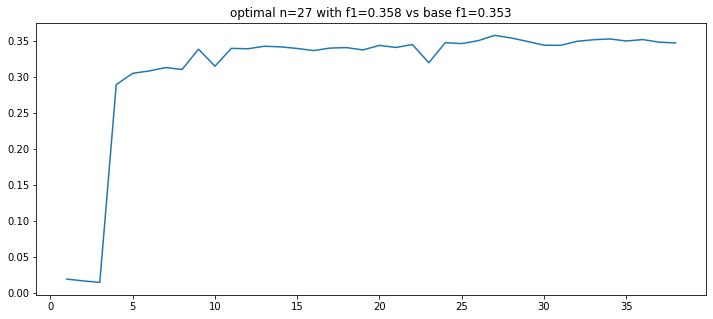

In [16]:
# 2.1.3. PLot
fig = plt.figure(figsize=(12, 5))
plt.title(f'optimal n={best_n} with f1={np.array(f1_list).max():.3f} vs base f1={f1_test_base:.3f}')
sns.lineplot(x=feature_range, y=f1_list)
plt.show()

In [17]:
# 2.2. RFE feature selection. XGB Boost

# 2.2.1. Calculation
STEP = 5

selector = RFECV(estimator=clf, step=STEP, cv=StratifiedKFold(2), scoring='f1', n_jobs=-1)
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

X_train_cutted = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_cutted = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf, f1_test = tree_fit_predict(clf, X_train_cutted, y_train_balanced, X_test_cutted, y_test, 
                                       show_metrics=False)
print(f'for selected features achieved f1={f1_test:.3f} vs default f1={f1_test_base:.3f}')

Optimal number of features : 50
for selected features achieved f1=0.347 vs default f1=0.353


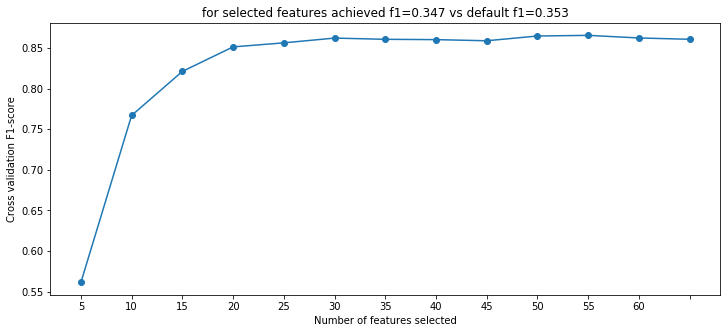

In [18]:
# 2.2.2. Recalc and Plot
title = f'for selected features achieved f1={f1_test:.3f} vs default f1={f1_test_base:.3f}'

plt.figure(figsize=(12,5))
plt.title(title)
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

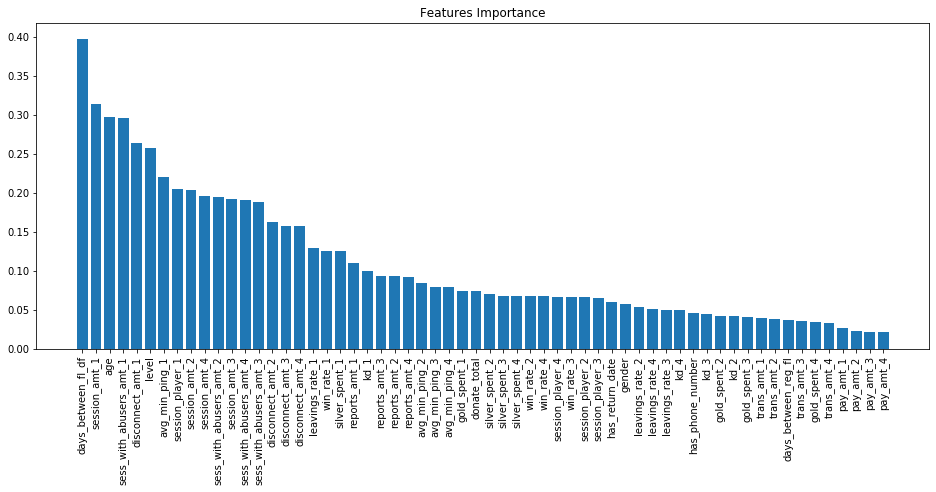

non-zero features number: 59


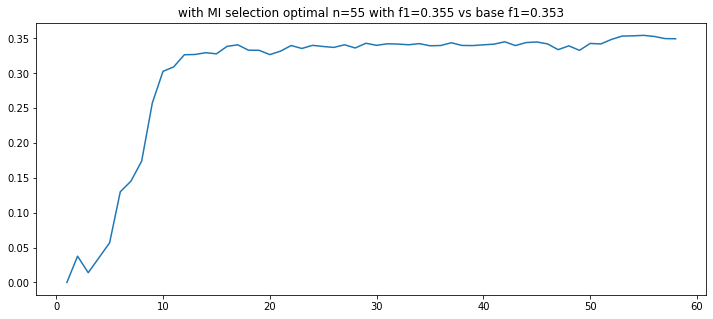

In [19]:
# 2.3. Mutual Info
# takes up to 15 minutes

mi = mutual_info_classif(X_train_balanced, y_train_balanced)
feature_importance = plot_importance(mi, X.columns, 'Features Importance', plot=True)

zero_feats = feature_importance[1].value_counts().max()
non_zero_feats = len(feature_importance) - zero_feats
print(f'non-zero features number: {non_zero_feats}')

feature_range = range(1, non_zero_feats)
f1_list = []

for n in feature_range:
    X_train_cutted = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:n]]
    X_test_cutted = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:n]]
    fitted_clf, f1_test = tree_fit_predict(clf, X_train_cutted, y_train_balanced, X_test_cutted, y_test, 
                                           show_metrics=False)
    f1_list.append(f1_test)
    
best_idx = np.array(f1_list).argmax()
best_n = feature_range[best_idx]

fig = plt.figure(figsize=(12, 5))
plt.title(f'with MI selection optimal n={best_n} with f1={np.array(f1_list).max():.3f} vs base f1={f1_test_base:.3f}')
sns.lineplot(x=feature_range, y=f1_list)
plt.show()

Выводы по XGBoost: наилучший вариант:
- базовый отбор признаков по значимости (27) признаков, который слегка увеличивает f1_score c 0.353 до 0.358

### Feature selection. RANDOM FOREST and Single Decision Tree

In [36]:
# 3.1 Model instances

# примечание: я не стал подбирать гиперпараметры, взял похожие с XGboost, где применимо
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


clf_dt = DecisionTreeClassifier(max_depth=10,
                                random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100,
                                max_depth=3,
                                random_state=42,
                                n_jobs=-1)


Precision: 0.2588157894736842
Recall: 0.4742044358727097
F1: 0.33486550902281237
Log Loss: 0.1624804079635697
ROC AUC: 0.8831172272432313


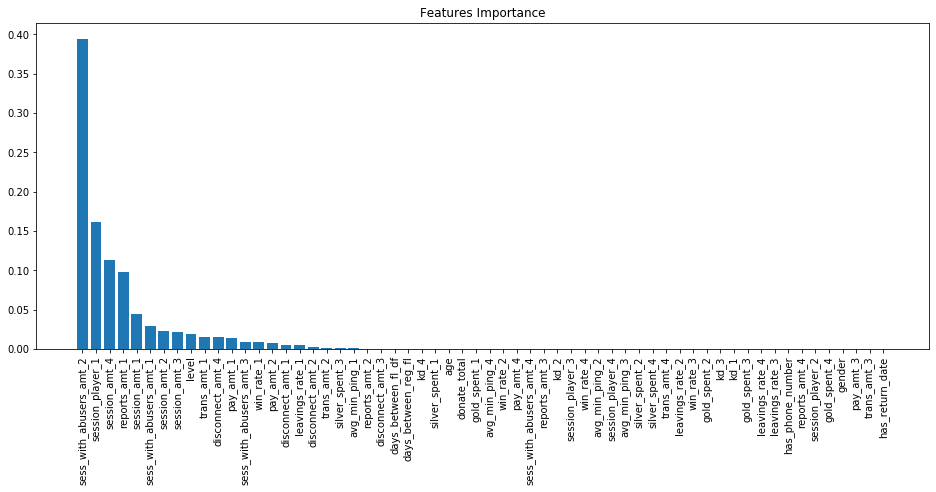

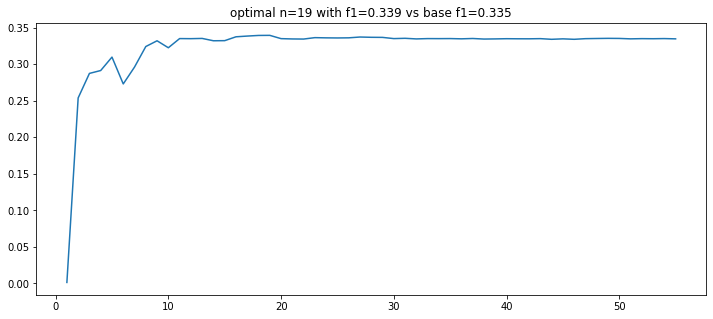

In [40]:
# 3.2. Single Decision Tree 

# 3.2.1. Standart Selection

fitted_clf, f1_test_base = tree_fit_predict_dt(clf_dt, X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance = plot_importance(fitted_clf.feature_importances_, X.columns, 'Features Importance', plot=True)

zero_feats = feature_importance[1].value_counts().max()
non_zero_feats = len(feature_importance) - zero_feats
feature_range = range(1, non_zero_feats)
f1_list = []

for n in feature_range:
    X_train_cutted = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:n]]
    X_test_cutted = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:n]]
    fitted_clf, f1_test = tree_fit_predict_dt(clf_dt, X_train_cutted, y_train_balanced, X_test_cutted, y_test, 
                                           show_metrics=False)
    f1_list.append(f1_test)
    
best_idx = np.array(f1_list).argmax()
best_n = feature_range[best_idx]

fig = plt.figure(figsize=(12, 5))
plt.title(f'optimal n={best_n} with f1={np.array(f1_list).max():.3f} vs base f1={f1_test_base:.3f}')
sns.lineplot(x=feature_range, y=f1_list)
plt.show()

In [ ]:
# 3.2.2. DT. RFE

STEP = 5

selector = RFECV(estimator=clf_dt, step=STEP, cv=StratifiedKFold(2), scoring='f1', n_jobs=-1)
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

X_train_cutted = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_cutted = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf, f1_test = tree_fit_predict_dt(clf_dt, X_train_cutted, y_train_balanced, X_test_cutted, y_test, 
                                       show_metrics=False)
print(f'for selected features achieved f1={f1_test:.3f} vs default f1={f1_test_base:.3f}')

title = f'for selected features achieved f1={f1_test:.3f} vs default f1={f1_test_base:.3f}'

plt.figure(figsize=(12,5))
plt.title(title)
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

In [ ]:
# 3.2.3. DT. MI
# --. No need to recalc mi-object (it is not depends on model instance)

feature_importance = plot_importance(mi, X.columns, 'Features Importance', plot=True)

zero_feats = feature_importance[1].value_counts().max()
non_zero_feats = len(feature_importance) - zero_feats
print(f'non-zero features number: {non_zero_feats}')

feature_range = range(1, non_zero_feats)
f1_list = []

for n in feature_range:
    X_train_cutted = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:n]]
    X_test_cutted = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:n]]
    fitted_clf, f1_test = tree_fit_predict_dt(clf_dt, X_train_cutted, y_train_balanced, X_test_cutted, y_test, 
                                           show_metrics=False)
    f1_list.append(f1_test)
    
best_idx = np.array(f1_list).argmax()
best_n = feature_range[best_idx]

fig = plt.figure(figsize=(12, 5))
plt.title(f'with MI selection optimal n={best_n} with f1={np.array(f1_list).max():.3f} vs base f1={f1_test_base:.3f}')
sns.lineplot(x=feature_range, y=f1_list)
plt.show()

In [ ]:
# 3.3. Random Forest

# 3.3.1. Standart Selection

fitted_clf, f1_test_base = tree_fit_predict(clf_rf, X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance = plot_importance(fitted_clf.feature_importances_, X.columns, 'Features Importance', plot=True)

zero_feats = feature_importance[1].value_counts().max()
non_zero_feats = len(feature_importance) - zero_feats
feature_range = range(1, non_zero_feats)
f1_list = []

for n in feature_range:
    X_train_cutted = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:n]]
    X_test_cutted = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:n]]
    fitted_clf, f1_test = tree_fit_predict(clf_rf, X_train_cutted, y_train_balanced, X_test_cutted, y_test, 
                                           show_metrics=False)
    f1_list.append(f1_test)
    
best_idx = np.array(f1_list).argmax()
best_n = feature_range[best_idx]

fig = plt.figure(figsize=(12, 5))
plt.title(f'optimal n={best_n} with f1={np.array(f1_list).max():.3f} vs base f1={f1_test_base:.3f} on LIGHT')
sns.lineplot(x=feature_range, y=f1_list)
plt.show()

In [ ]:
# 3.3.2. RF. RFE

STEP = 5

selector = RFECV(estimator=clf_rf, step=STEP, cv=StratifiedKFold(2), scoring='f1', n_jobs=-1)
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

X_train_cutted = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_cutted = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf, f1_test = tree_fit_predict(clf_rf, X_train_cutted, y_train_balanced, X_test_cutted, y_test, 
                                       show_metrics=False)
print(f'for selected features achieved f1={f1_test:.3f} vs default f1={f1_test_base:.3f}')

title = f'for selected features achieved f1={f1_test:.3f} vs default f1={f1_test_base:.3f}'

plt.figure(figsize=(12,5))
plt.title(title)
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

In [ ]:
# 3.3.3. RF. MI
# --. No need to recalc mi-object (it is not depends on model instance)

feature_importance = plot_importance(mi, X.columns, 'Features Importance', plot=True)

zero_feats = feature_importance[1].value_counts().max()
non_zero_feats = len(feature_importance) - zero_feats
print(f'non-zero features number: {non_zero_feats}')

feature_range = range(1, non_zero_feats)
f1_list = []

for n in feature_range:
    X_train_cutted = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:n]]
    X_test_cutted = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:n]]
    fitted_clf, f1_test = tree_fit_predict(clf_rf, X_train_cutted, y_train_balanced, X_test_cutted, y_test, 
                                           show_metrics=False)
    f1_list.append(f1_test)
    
best_idx = np.array(f1_list).argmax()
best_n = feature_range[best_idx]

fig = plt.figure(figsize=(12, 5))
plt.title(f'with MI selection optimal n={best_n} with f1={np.array(f1_list).max():.3f} vs base f1={f1_test_base:.3f}')
sns.lineplot(x=feature_range, y=f1_list)
plt.show()

### Feature Importance, как атрибут модели

Некоторые модели, такие как XGBoost, LGBMClassifier, RandomForestRegressor и др., имеют атрибут __feature\_importances\___, который показывает, насколько важен каждый из признаков. Эта "важность" может расчитываться как, например, путем суммирования прироста качества при разбиении узлов дерева по этому признаку, или же равняться количеству разбиений в дереве, которые произошли по данному признаку.

Посмотрим на примере XGBoost, как это выглядит.

Попробуем обучить модель на Топ-30 признаках и оценить качество.

In [ ]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Видим, что кол-во признаков уменьшили __вдвое__, а качество практически не изменилось.

Видим, что на отобранных Хи-квадратом признаках качество упало сильнее, чем при отборе Feature Impotrance модели, но в целом так же незначительно.

Для данного подхода и следующих в качестве __домашнего задания__ предлагается выбрать N лучших признаков по рассчитанной метрике и посмотреть качество предсказания на них.

### RFE (Recursive Feature Elimination)

Рекурскивный отсев признаков - убираем на каждой итерации самые слабые признаки и делаем это до тех пор, пока не увидим заметного снижения качества. На каком кол-ве признаков остановимся, то и считаем оптимальным.

In [ ]:
%%time
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

### Permutation Importance (PI)

Перемешивание значений столбца важного признака приводит к заметному снижению качества работы модели

In [ ]:
# Модуль можно установить, сделав
# !pip install eli5
# А можно использовать локальный модуль
from ELI5 import PermutationImportance

In [ ]:
%%time
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

In [ ]:
plt.figure(figsize=(16,6))
plt.bar(range(res.shape[0]), res['score'], yerr=res['std'], align='center')
plt.xticks(range(res.shape[0]), res['feature'], rotation=90)
plt.title('Permutation Importance')
plt.tight_layout()
plt.ylim(-0.001,0.012)
plt.show()

In [ ]:
good_features = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features.shape[0])

### WoE (Weight of Evidence) and IV (Information Value)

Простое, но в то же время мощное преобразование данных, позволяющее установить монотонную связь между признаками и целевой переменной, а IV может использоваться как мера важности признаков. Преобразование осуществляет корректную обработку как пропущенных значений, так и выбросов, поэтому предварительно обрабатывать датасет не нужно для WOE.

In [ ]:
# Для простоты расчетов используем локальный модуль
from WOE_IV import data_vars

dataset_raw = pd.read_csv('dataset/dataset_raw_train.csv', sep=';')
X_raw = dataset_raw.drop(['user_id', 'is_churned'], axis=1)
y_raw = dataset_raw['is_churned']

In [ ]:
%%time
# Рассчитаем IV
iv_df, iv = data_vars(X_raw, y_raw)

In [ ]:
IV = iv.sort_values('IV', ascending=False)
plt.figure(figsize=(16,6))
plt.bar(range(IV.shape[0]), IV['IV'], align='center')
plt.xticks(range(IV.shape[0]), IV['VAR_NAME'].values, rotation=90)
plt.title('Information Value')
plt.show()

In [ ]:
%%time
X_WOE = X_raw.copy()

for var in X_WOE.columns:
    small_df = iv_df.loc[iv_df['VAR_NAME'] == var]
    if type(small_df.loc[~small_df['MIN_VALUE'].isnull()]['MIN_VALUE'].values[0]) == str:
        small_df.loc[small_df['MIN_VALUE'].isnull(), 'MIN_VALUE'] = 'NaN'
        small_df.loc[small_df['MAX_VALUE'].isnull(), 'MAX_VALUE'] = 'NaN'
    else:
        small_df.loc[small_df['MIN_VALUE'].isnull(), 'MIN_VALUE'] = 0.
        small_df.loc[small_df['MAX_VALUE'].isnull(), 'MAX_VALUE'] = 0.
    transform_dict = dict(zip(small_df['MAX_VALUE'], small_df['WOE']))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd += str(i[1]) + ' if x <= ' + str(i[0]) + ' else '
        replace_cmd1 += str(i[1]) + ' if x == "' + str(i[0]) + '" else '
    replace_cmd += '0'
    replace_cmd1 += '0'
    if replace_cmd != '0':
        try:
            X_WOE[var] = X_WOE[var].apply(lambda x: eval(replace_cmd))
        except:
            X_WOE[var] = X_WOE[var].apply(lambda x: eval(replace_cmd1))

In [ ]:
X_train_WOE, X_test_WOE, y_train_WOE, y_test_WOE = train_test_split(X_WOE, 
                                                                    y_raw, 
                                                                    test_size=0.3,
                                                                    shuffle=True, 
                                                                    stratify=y_raw, 
                                                                    random_state=100)
X_train_WOE_balanced, y_train_WOE_balanced = SMOTE(random_state=42, ratio=0.3).fit_sample(X_train_WOE, y_train_WOE)

In [ ]:
# Выделим значимые признаки, для таких признаков IV не должно быть близко ни к 0, ни к 1
significant_features = IV.loc[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME']
print('Значимых признаков:', significant_features.nunique())

Из-за установления монотонной связи WOE преобразование тесно связано с логистической регрессией и в некотором смысле "подготавливает" датасет для logit'а. Посмотрим, какое качество получается на WOE датасете у логистической регрессии и сравним это с качеством на "обычном".

In [ ]:
%%time
logit = LogisticRegression(random_state=42)
logit.fit(X_train_WOE_balanced, y_train_WOE_balanced)

predict_proba_test = logit.predict_proba(X_test_WOE)
predict_test = logit.predict(X_test_WOE)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test_WOE, predict_test, predict_proba_test[:, 1])

In [ ]:
%%time
logit_2 = LogisticRegression(random_state=42)
logit_2.fit(X_train_balanced, y_train_balanced)

predict_proba_test = logit_2.predict_proba(X_test)
predict_test = logit_2.predict(X_test)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, predict_test, predict_proba_test[:, 1])

Как видим, WOE преобразованный датасет позволяет получить на дефолтном logit'е практически такое же качество, как XGBoost! При этом, для сравнения, тот же logit на обычном датасете показывает заметно худшее качество.

## Оценка качества модели

В качестве базового решения у нас модель XGBoost, которую мы обучили в начале урока. Проведем ее более комплексную оценку, для этого напишем несколько вспомогательных фукнций для более наглядной визуализации результатов.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    cm = np.array([[TP, FP],
                   [FN, TN]])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    # Plot both matrixes - basic and normalized
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    for ax, normalize, data, title in zip(ax,
                                          [False, True], 
                                          [cm, cm_normalized], 
                                          ['Confusion matrix (without normalization)', 
                                           'Сonfusion matrix (normalized)']):
        im = ax.imshow(data, interpolation='nearest', cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='Predicted label',
               xlabel='True label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')        
        # Loop over data dimensions and create text annotations
        fmt = '.2f' if normalize else 'd'
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt), ha="center", va="center", 
                        color="white" if data[i, j] > data.max() / 2. else "black")                
    fig.tight_layout()
    return fig 

def plot_PR_curve(y_true, y_pred, y_prob):
    AP = average_precision_score(y_true=y_true, y_score=y_prob)
    precisions, recalls, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_prob)
    
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR curve: AP={0:0.2f}'.format(AP))
    
def plot_ROC_curve(classifier, X, y, n_folds):
    
    cv = StratifiedKFold(n_splits=n_folds)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % \
             (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
model = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
predict_test = model.predict(X_test)
predict_test_probas = model.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test.values, predict_test, classes=['churn', 'active'])
plt.show()

In [ ]:
plot_PR_curve(y_test.values, predict_test, predict_test_probas)
plt.show()

In [ ]:
%%time
plot_ROC_curve(classifier=model, 
               X=X_test, 
               y=y_test.values, 
               n_folds=3)

In [ ]:
# Итоговую модель можно сохранить в файл

# with open('models/baseline_xgb.pcl', 'wb') as f:
#     pickle.dump(model, f)

### Литература


1. [XGBoost Docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html)
2. [sklearn.feature_selection ](https://scikit-learn.org/stable/modules/feature_selection.html)
3. [Feature Selection with sklearn and Pandas](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b)
4. [Weight of evidence and Information Value using Python](https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb)
5. [Weight of Evidence(WOE) and Information Value(IV)](https://www.kaggle.com/pavansanagapati/weight-of-evidence-woe-information-value-iv)

### Д/З

1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?
2. Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.
3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.
4. __(*)__ Как думаете, можно ли производить отбор признаков с помощью IV, а затем обучать модель случайного леса на отфильтрованном датасете? Ответ обоснуйте. 